# Implementations (v1)
## Classical Machine Learning Algorithms

- [x] K-Nearest Neighbours
- [ ] K-Means
- [x] Linear Regression
- [x] Logistic Regression
- [ ] Naive Bayes
- [ ] Decision Tree
- [ ] Random Forest

---

## Supplementary 

- Mean-Squarred Error Loss
- Binary Cross Entropy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import heapq, collections

### Data

In [2]:
from sklearn.datasets import make_classification, make_regression
class_x, class_y = make_classification(n_samples = 1000, n_features = 32, n_classes=5, n_informative = 16)
binclass_x, binclass_y = make_classification(n_samples = 1000, n_features = 32, n_classes=2)
reg_x, reg_y = make_regression(n_samples = 1000, n_features = 32,)

## K-Nearest Neighbours

In [3]:
class KNearestNeighbour:
      
    def __init__(self, k:int, distance_fn = None):
        self.k = k
        self.distance_fn = distance_fn if distance_fn else self._euclidean_distance
  
    def fit(self, X:np.ndarray, Y:np.ndarray):
        self.X = X
        self.Y = Y
    
    def _euclidean_distance(self, xᵢ, xⱼ):
#         Alternatively use scipy.spatial.distance.euclidean(xᵢ, xⱼ) or np.norm(np.sqrt(xᵢ - xⱼ), ord = 2)
        return np.sqrt(np.sum( np.square(xᵢ - xⱼ)))
    
    def _vote(self, neighbours):
        vote_count = collections.OrderedDict({})
        for (distance, yᵢ) in neighbours:
            vote_count[yᵢ] = vote_count.get(yᵢ, 0) + 1
        return vote_count.popitem(last = False)[0]

    def predict(self, x̂ᵢ) -> int:
        distances = []
        for xᵢ,yᵢ in zip(self.X, self.Y):
            heapq.heappush(distances, (self._euclidean_distance(xᵢ, x̂ᵢ), yᵢ))
        neighbours = heapq.nsmallest(self.k, distances)
        ŷᵢ = self._vote(neighbours)
        return ŷᵢ

In [4]:
knn = KNearestNeighbour(5)
knn.fit(class_x, class_y)
knn.predict(class_x[0]), class_y[0]

(0, 0)

## K-Means

In [5]:
class KMeans:
    
    def __init__(self, k:int = 5, distance_fn = None, epochs:int = 500):
        self.k = k
        self.distance_fn = distance_fn if distance_fn else self._euclidean_distance
        self.epochs = epochs
        
    def _iterate(self):
        μbuckets = {}
        for xᵢ in self.X:
            d̃min = float('inf')
            μclosest = self._forward(xᵢ)
            μbuckets[μclosest] = μbuckets.get(μclosest,[]) + [xᵢ]
        self.μlist = []
        for μ, bucket in μbuckets.items():
            np_bucket = np.asarray(bucket)
            μnew = np.asarray([np.mean(np_bucket[:,0]), np.mean(np_bucket[:,1])])
            self.μlist.append(μnew)
                
    def _train(self):
        for epoch in range(self.epochs):
            self._iterate()
    
    def _euclidean_distance(self, xᵢ, xⱼ):
        return np.sqrt(np.sum( np.square(xᵢ - xⱼ)))
    
    
    def _forward(self, xᵢ):
        d̃min = float('inf')
        μclosest = None
        for μ in self.μlist:
            d̃current = self.distance_fn(μ, xᵢ) 
            if d̃current < d̃min:
                d̃min = d̃current
                μclosest = μ
#         print(μclosest,tuple(μclosest.tolist()))
        return tuple(μclosest.tolist())
    
    def predict(self, X):
        return np.asarray([self._forward(xᵢ) for xᵢ in X])
    
    def fit(self, X):
        self.X = X
        self.μlist = self.X[np.random.choice(len(self.X), size=self.k)]
        self._train()
        

In [6]:
kmeans_x, kmeans_y = make_classification(n_samples = 500, n_features = 2, n_classes=2, n_redundant = 0,  n_informative = 2, n_repeated = 0 )

In [7]:
kmeans = KMeans(k = 2, epochs=500)
kmeans.fit(kmeans_x)

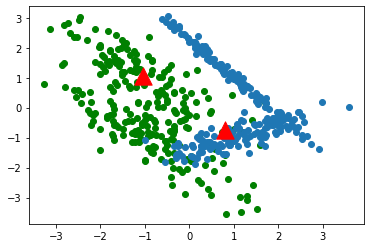

In [22]:
kmeans.μlist = np.asarray(list(map(lambda x : list(x),kmeans.μlist)))
plt.scatter(kmeans_x[kmeans_y==0][:,0],kmeans_x[kmeans_y==0][:,1], c ='green')
plt.scatter(kmeans_x[kmeans_y==1][:,0],kmeans_x[kmeans_y==1][:,1])
plt.scatter(kmeans.μlist[:,0],kmeans.μlist[:,1], marker='^', s=300, c = 'red')
plt.show()

## Linear Regression

**Forward:**
$$ \hat{y}_i = wx_i + b $$
**Mean Squarred Error (MSE):** $$ \ell = \frac{1}{n}\sum_i^n(y_i- \hat{y}_i)^2$$

**Gradient:**
$$ \frac{\partial \ell}{\partial w} = -(Y - \hat{Y}) X$$
$$ \frac{\partial \ell}{\partial b} = -(Y - \hat{Y})$$

**Update:**
$$w_{i} = w_{i-1} - \alpha\frac{\partial \ell}{\partial w}X$$
$$b_{i} = b_{i-1} - \alpha\frac{\partial \ell}{\partial b}$$

In [9]:
class MeanSquarredError:
    
    def _mse(self,Y, Ŷ):
        ℓ = np.mean(np.square(np.subtract(Y, Ŷ)))
        return ℓ
    
    def __init__(self):
        pass
    
    def compute(self, Y, Ŷ):
        return self._mse(Y, Ŷ)

In [10]:
class LinearRegression:
    
    def __init__(self, epochs:int = 500, loss = None, α:float = 1e-3):
        self.w = self.b = None
        self.loss = loss
        self.epochs = epochs
        self.α = α
        
    def _forward(self, X):
        # np.multiply perform elementwise mulitplication of X with vector w, equivalent: self.w * self.X, so avoid using loop as w is broadcasted.
        Ŷ = np.add(np.dot(X, self.w), self.b)
        return Ŷ
    
    def _grad(self, Ŷ):
        # think in terms of colum picture matrix: (32,1000) X (1000,): each component corresponding to a wᵢ ( which 1000,) has been multiplied by the residual of shape (1000,)
        self.Δℓw = np.matmul(np.transpose(-self.X), np.subtract(self.Y, Ŷ))
        self.Δℓb = np.matmul(np.full((*self.b.shape,self.X.shape[0]),-1), np.subtract(self.Y, Ŷ))
    
    def _step(self):
        self.w = self.w -  (self.α * self.Δℓw)
        self.b = self.b -  (self.α * self.Δℓb)
        
    def _iterate(self):
        Ŷ = self._forward(self.X)
        ℓ = self.loss.compute(self.Y, Ŷ)
        self._grad(Ŷ)
        self._step()
        return ℓ
    
    def _train(self):
        self.loss_dict = collections.OrderedDict({})
        for epoch in range(1, self.epochs+1):
            ℓ = self._iterate()
            self.loss_dict[epoch] = ℓ 
        
    def fit(self, X:np.ndarray, Y:np.ndarray):
        self.X = X
        self.Y = Y
        if len(self.Y.shape) > 1:
            self.w = np.random.rand(self.X.shape[1] * self.Y.shape[1])
            self.b = np.random.rand(self.Y.shape[1:])
        else:
            self.w = np.random.randn(self.X.shape[1])
            self.b = np.random.rand(1)
        self._train()
    
    def predict(self, x̂ᵢ):
        ŷᵢ = self._forward(x̂ᵢ)
        return ŷᵢ

In [11]:
lr = LinearRegression( loss = MeanSquarredError())
lr.fit(reg_x, reg_y)

In [12]:
lr.predict(reg_x[0]),reg_y[0]

(array([261.78709052]), 261.78709051847363)

## Binary Cross Entropy

$$\ell_{BCE} (y,\hat{y}) =  \frac{1}{n}\sum_i^n y_i\log \hat{y_i} + (1-y_i)\log (1-\hat{y_i})$$

In [13]:
class BinaryCrossEntropy:
    
    def _bce(self,Y, Ŷ):
        ℓ = - np.mean(
            (Y * np.log(Ŷ)) + 
            (1-Y * np.log(1-Ŷ))
        )
        return ℓ
    
    def __init__(self):
        pass
    
    def compute(self, Y, Ŷ):
        return self._bce(Y, Ŷ)

## Logistic Regression

**Forward:**
$$ \hat{y}_i = \sigma(wx_i + b)$$
**Binary Cross Entropy (BCE):** $$ \ell = \frac{1}{n}\sum_i^n(y_i- \hat{y}_i)^2$$

**Gradient:**
$$ \frac{\partial \ell}{\partial w} = -(Y - \hat{Y}) X$$
$$ \frac{\partial \ell}{\partial b} = -(Y - \hat{Y})$$

**Update:**
$$w_{i} = w_{i-1} - \frac{\partial \ell}{\partial w}X$$
$$b_{i} = b_{i-1} - \frac{\partial \ell}{\partial b}$$

In [14]:
class LogisticRegression:
    
    def __init__(self, epochs:int = 100, loss_fn = None, α:float = 1e-3, Θ:float = 0.5):
        self.w = self.b = None
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.α = α
        self.Θ = Θ
        
    def σ(self, Ƶ):
        return 1/(1 + np.exp(-Ƶ))
    
    def Δσ(self, Ƶ):
        return self.σ(Ƶ) * (1-self.σ(Ƶ))
    
    def _forward(self, X):
        Ƶ = np.dot(X, self.w) + self.b
        return Ƶ
    
    def _grad(self, Ŷ, Ƶ):
        self.Δℓw = np.matmul(
            np.transpose(self.X),
            (self.Δσ(Ƶ) * ( (1 - self.Y/ 1- Ŷ) -  (self.Y/Ŷ) ))
        )
        self.Δℓb = np.matmul(
            np.full((*self.b.shape, self.X.shape[0]), 1),
            (self.Δσ(Ƶ) * ( (1 - self.Y/ 1- Ŷ) -  (self.Y/Ŷ) ))
        )
    
    def _step(self):
        self.w = self.w - (self.α * self.Δℓw)
        self.b = self.b -  (self.α * self.Δℓb)
        
    def _iterate(self):
        Ƶ =self._forward(self.X)
        Ŷ = self.σ(Ƶ)
        ℓ = self.loss_fn.compute(self.Y, Ŷ)
        self._grad(Ŷ, Ƶ)
        self._step()
        return ℓ
    
    def _train(self):
        self.loss_dict = collections.OrderedDict({})
        for epoch in range(1, self.epochs+1):
            ℓ = self._iterate()
            self.loss_dict[epoch] = ℓ 
        
    def fit(self, X:np.ndarray, Y:np.ndarray):
        self.X = X
        self.Y = Y
        if len(self.Y.shape) > 1:
            self.w = np.random.rand(self.X.shape[1] * self.Y.shape[1])
            self.b = np.random.rand(self.Y.shape[1:])
        else:
            self.w = np.random.randn(self.X.shape[1])
            self.b = np.random.rand(1)
        self._train()
    
    def predict(self, x̂ᵢ):
        Ƶ =self._forward(x̂ᵢ)
        ŷᵢ = self.σ(Ƶ)
        return 1 if ŷᵢ >= self.Θ else 0

In [15]:
lr = LogisticRegression(loss_fn = BinaryCrossEntropy())
lr.fit(binclass_x, binclass_y)

In [16]:
lr.predict(binclass_x[0]),binclass_y[0]

(0, 0)

## Decision Tree